# Comment réaliser simplement des cartes à partir de données ponctuelles sous Python - l'exemple des terrasses éphémères à Paris

L'objectif de ce notebook est d'indiquer comment il est possible, simplement, de créer des cartes sous Python à partir de données géolocalisées (latitude et longitude connus). 3 types de cartes sont ainsi couvertes : 
- des cartes "simples" plaçant tous les points souhaités
- des cartes dans lesquelles les données ont été regroupées dans des carreaux (très utile pour apparier avec les données carroyées de l'Insee, par exemple)
- des cartes de densité lissée, très utile pour représenter de façon synthétique les zones de forte concentration

## Etape 1 : gestion des librairies

Ce travail nécessite différentes librairies. Dans le datalab, seules celles qui ne sont pas installées par défaut doivent être téléchargées et installées, via l'instruction "!pip install -q -q -q" (le -q permettant d'éviter l'affichage de textes de validation -q pour "quiet"). Ce choix de nombre de librairies à installer dépend bien sûr de l'installation utilisée.

Les principales librairies à utiliser ici sont : 
- geopanda
- btbpy
- mapclassify
- contextily
- shapely.geometry : pour pouvoir créer des carreaux
- urllib.request : pour télécharger la page des terrasses

In [50]:
!pip install -q -q -q geopandas
!pip install -q -q -q btbpy
!pip install -q -q -q mapclassify
!pip install -q -q -q contextily
!pip install -q -q -q rtree

In [1]:
import os
import s3fs
import urllib.request

import numpy as np
import pandas as pd
import geopandas as gpd
import btbpy as btb
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import contextily as cx

## Terrasses Ephémères : Chargement des données

L'objectif de ce notebook est d'illustrer le traitement de données géographiques dans le cas, actuel, des terrasses éphémères autorisées cette année à Paris. Ces données sont disponibles en open data, et contiennent les coordonnées géographiques en x/y de chaque terrasse

On commence par télécharger les données 

In [2]:
url = 'https://opendata.paris.fr/explore/dataset/terrasses-ephemeres/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
urllib.request.urlretrieve(url, 'terrasses.csv')

('terrasses.csv', <http.client.HTTPMessage at 0x7f3c5187ab50>)

Puis on les ouvre, ce qui permet de vérifier les données qui sont présentes. On renomme, par souci de simplicité, la colonne 'Coord X' par 'x' et 'Coord Y' par 'y'

In [3]:
terrasses = pd.read_csv('terrasses.csv', sep=';' )
terrasses = terrasses.rename({'Coord X' :'x', 'Coord Y':'y'}, axis='columns')
terrasses['densite'] = 1
terrasses = terrasses[(terrasses.x>0) & (terrasses.x<658000)] # pour enlever les terrasses en dehors de Paris

In [4]:
terrasses.head(2)

Référence déclaration         Nom du commerce  \
0                21388.0               Le bailly   
1                 2146.0  Brasserie LE CARREFOUR   

              Adresse du commerce            x             y  \
0                  27 RUE REAUMUR  652804.0773  6.862992e+06   
1  50 rue de Laborde, 75008 PARIS  649837.8207  6.864153e+06   

                                           geo_shape  \
0  {"type": "Point", "coordinates": [2.3566600042...   
1  {"type": "Point", "coordinates": [2.3160911274...   

                  geo_point_2d  densite  
0  48.8652300122,2.35666000429        1  
1  48.8754426135,2.31609112743        1

## Transformation en un fond spatial des données > Carte des emplacements !

Les données sont stockées dans un panda DataFrame appelé "terrasse". Pour en faire une carte, il faut d'abord transformer le dataframe en un 'GeoDataFrame', cad un tableau de données incluant des coordonnées géographiques.  Ceci revient à créer la variable geometry qui contient des points. Pour cela, il suffit d'utiliser la fonction 'GeoDataFrame' du package geopandas. Celle-ci prend trois arguments :
- le nom du dataframe de base
- les coordonnées des points (ici en XY, ce qui nécessite d'utiliser la fonction 'points_from_xy')
- la projection dans laquelle les coordonnées X,Y sont fournies

La question de la projection est importante, toute coordonnée spatiale devant nécessairement être associée à une projection. Les coordonnées ne se lisent en effet pas de la même façon selon que la localisation du point de départ des absices, ou selon les choix qui ont été faits au moment de la transformation de la sphère terrestre en un plan.

La distinction entre les projections existantes dépasse le cadre de ce notebook (beaucoup de ressources existent sur le sujet, dont un document de travail du SSP Lab en cours de finalisation) : ici, il suffit de savoir que le petit nom de la projection est 'EPSG:2154', argument qui doit être donné pour la fonction. Cette information est souvent rendue disponible lors du téléchargement des bases.

In [5]:
sterrasses = gpd.GeoDataFrame(terrasses, geometry=gpd.points_from_xy(terrasses.x, terrasses.y), crs='EPSG:2154')

In [6]:
sterrasses.head(2)

Référence déclaration         Nom du commerce  \
0                21388.0               Le bailly   
1                 2146.0  Brasserie LE CARREFOUR   

              Adresse du commerce            x             y  \
0                  27 RUE REAUMUR  652804.0773  6.862992e+06   
1  50 rue de Laborde, 75008 PARIS  649837.8207  6.864153e+06   

                                           geo_shape  \
0  {"type": "Point", "coordinates": [2.3566600042...   
1  {"type": "Point", "coordinates": [2.3160911274...   

                  geo_point_2d  densite                        geometry  
0  48.8652300122,2.35666000429        1  POINT (652804.077 6862992.170)  
1  48.8754426135,2.31609112743        1  POINT (649837.821 6864152.745)

A ce stade, on peut tracer la carte avec les différents points, ce qui se réalise par l'instruction "plot" associé au GeoDataFrame qu'on a appelé "sterrasses" au desssus : sterrasses.plot()

Afin que la carte soit plus lisible cependant :
- on enlève l'affichage des axes
- on ajoute un titre
- et surtout, on ajoute un fond de carte de Paris ! 

Ceci se réalise à partir de l'instruction suivante : 
cx.add_basemap(ax, crs=sterrasses.crs.to_string(), source=cx.providers.Stamen.TonerLite)

Les deux éléments importants de la fonction sont :
- le fait que le fond de carte se télécharge au niveau des coordonnées des données (sterrasses.crs)
- qu'on utilise un provider exterieur et un style à partir de l'instruction cx.providers.Stamen.TonerLite

Avec l'ensemble de ces éléments, **on dispose désormais d'une jolie carte !**


(6857121.84, 6867229.71)

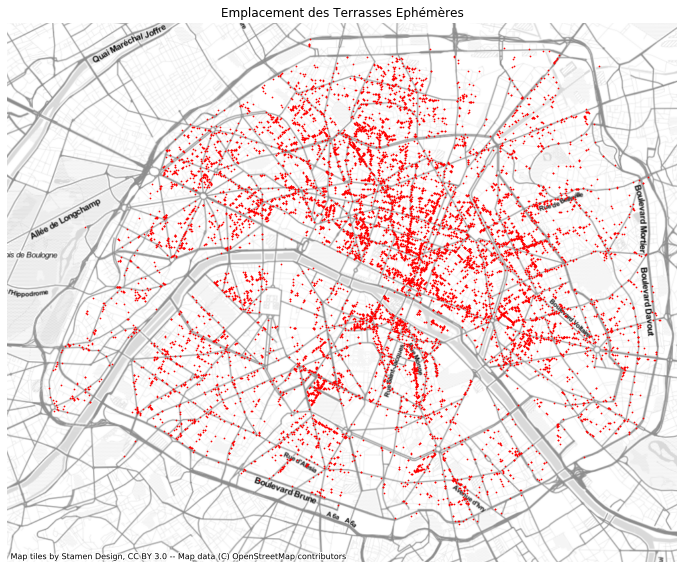

In [7]:
ax = sterrasses.plot(markersize=0.5, figsize=(12,14), color='red') #figsize définit la taille de la carte
ax.set_axis_off()
cx.add_basemap(ax, crs=sterrasses.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_title("Emplacement des Terrasses Ephémères")
ax.set_xlim((644601.05,657161.71))
ax.set_ylim((6857121.84,6867229.71))

## Synthétiser les données : Création de données carroyées

Une carte de points est utile pour décrire l'organisation des terrasses éphémères. Elle s'avére néanmoins insufisante si l'on souhaite étudier les phénomènes qui expliquent la localisation des terrasses. Recourir à un découpage de l'espace spatiale permet de calculer simplement des corrélations entre le nombres de terrasses et d'autres variables.

L'idée pour cela est simplement de découper la carte virtuellement en carreaux, et de compter ensuite à quel carreau chaque ligne appartient. 

In [8]:
size = 200 # On définit la taille souhaitée
lterrasses = terrasses.copy() # On crée une copie du tableau de données pour la manipuler
lterrasses.x = np.floor(lterrasses.x / size) * size + size / 2 # calcul du centre x du carreau d'appartenance 
lterrasses.y = np.floor(lterrasses.y / size) * size + size / 2 # calcul du centre x du carreau d'appartenance

Ensuite, on aggrége les données (par x et y, qui sont les coordonnées des centres des carreaux) pour obtenir une table de carreaux. Par construction dans notre exemple, l'origine de la grille des carreaux est fixée à (0,0). 

La géométrie d'un carreau est entièrement déterminée par la localisation de ses 4 sommets. La fonction Polygon permet de créer un polygone à partir d'une liste de sommets. 

In [9]:
lterrasses = lterrasses.groupby(by=['x', 'y'], as_index=False)['densite'].sum() 
lterrasses.densite = lterrasses.densite * 25 # pour obtenir une densité en km²
geometry = [Polygon([(x-size/2, y-size/2),
                     (x-size/2, y+size/2),
                     (x+size/2, y+size/2),
                     (x+size/2, y-size/2)])  for x,y in zip(lterrasses.x,lterrasses.y) ]
lterrasses =  gpd.GeoDataFrame(lterrasses, geometry=geometry, crs='EPSG:2154')                            

La variable geometry contient à présent des polygons (des carreaux).

In [10]:
lterrasses.head(2)

x          y  densite  \
0  645300.0  6860300.0       50   
1  645500.0  6859900.0       75   

                                            geometry  
0  POLYGON ((645200.000 6860200.000, 645200.000 6...  
1  POLYGON ((645400.000 6859800.000, 645400.000 6...

On trace maintenant la carte de densité, toujous à l'aide de la fonction plot : 

- legend=True : permet l'affichage de la légende ;
- scheme : est la méthode de discrétisation pour définir les bornes des classes. Il est recommandé a priori d'utiliser 'FisherJenksSampled' ou 'Quantiles'. Vous trouverez un résumé des méthodes de discrétisation dans cette [vidéo](https://fr.coursera.org/lecture/cartographie/5-1-les-differentes-methodes-de-discretisation-HHZLS) ;
- cmap : définit le choix de la rampe de couleurs. Dans notre exemple, nous avons choisi un dégradé de rouges. La page <https://matplotlib.org/stable/tutorials/colors/colormaps.html> liste tous les dégradés disponibles ;  
- alpha : définit le niveau de transparence.


(6857121.84, 6867229.71)

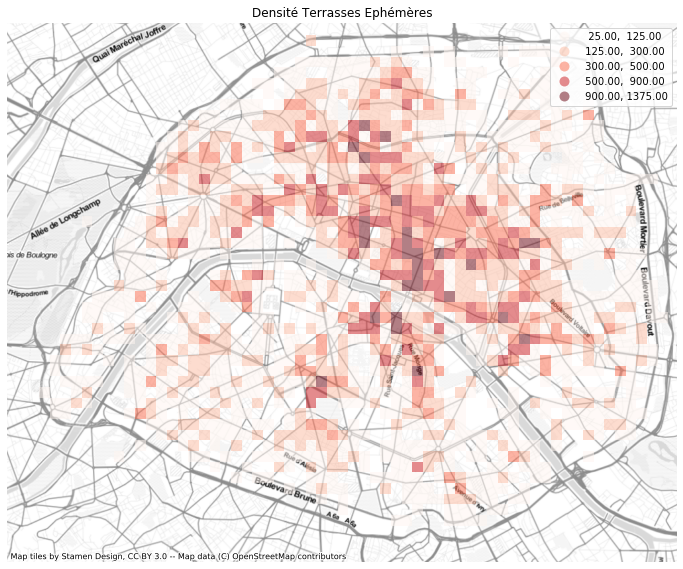

In [11]:
ax = lterrasses.plot('densite', figsize=(12,14), legend=True, scheme='FisherJenksSampled', cmap='Reds', alpha=0.5)
ax.set_axis_off()
cx.add_basemap(ax, crs=sterrasses.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_title("Densité Terrasses Ephémères")
ax.set_xlim((644601.05,657161.71))
ax.set_ylim((6857121.84,6867229.71))

## Synthétiser les données : utiliser une grille carroyées préexistante

Si l'on dispose déjà d'un fond de carte, on recourt à une [jointure spatiale](https://geopandas.org/docs/user_guide/mergingdata.html) pour dénombrer les terrasses (les points) dans les carreaux. 

On charge tout d'abord la table des données carroyées Filosofi 2015 disponible sous minio à l'aide de la librairie s3fs. 

In [12]:
import s3fs
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('ssplab/funathon/data/filosofi2015/filosofi.gpkg', 'filosofi.gpkg')

filosofi = gpd.read_file('filosofi.gpkg')
filosofi.drop('index_right', axis=1, inplace=True) # pour éviter un bug avec le sjoin 

In [20]:
filosofi.columns

Index(['IdINSPIRE', 'Id_carr1km', 'I_est_cr', 'Id_carr_n', 'Groupe', 'Depcom',
       'I_pauv', 'Id_car2010', 'Ind', 'Men', 'Men_pauv', 'Men_1ind',
       'Men_5ind', 'Men_prop', 'Men_fmp', 'Ind_snv', 'Men_surf', 'Men_coll',
       'Men_mais', 'Log_av45', 'Log_45_70', 'Log_70_90', 'Log_ap90', 'Log_inc',
       'Log_soc', 'Ind_0_3', 'Ind_4_5', 'Ind_6_10', 'Ind_11_17', 'Ind_18_24',
       'Ind_25_39', 'Ind_40_54', 'Ind_55_64', 'Ind_65_79', 'Ind_80p',
       'Ind_inc', 'I_est_1km', 'code', 'libelle', 'cheflieu', 'tncc', 'dct',
       'dar', 'dau10', 'typo_au10', 'duu10', 'z10', 'epc', 'bv', 'cdcte',
       'dep', 'reg', 'surf', 'geometry'],
      dtype='object')

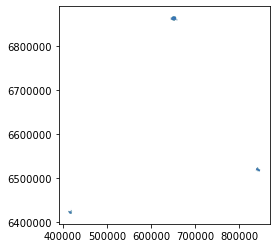

In [13]:
filosofi.plot()

On filtre sur les coordonnées pour se restreindre à Paris :

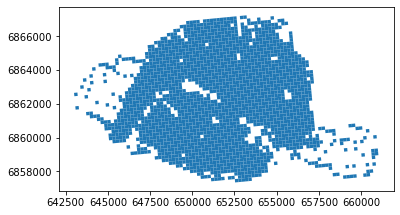

In [14]:
filosofi = filosofi.cx[600000:700000,:] 
filosofi.plot()

La fonction sjoin permet de réaliser la jointure. Attention, les deux couches doivent partager la même projection.

In [27]:
temp = gpd.sjoin(sterrasses, filosofi, how="inner", op='intersects')

In [28]:
cterrasses = temp.groupby(['IdINSPIRE'], as_index=False)['densite'].sum()
cterrasses.densite = cterrasses.densite / 0.2**2

In [29]:
cterrasses = filosofi.merge(cterrasses, on = 'IdINSPIRE')

(6857121.84, 6867229.71)

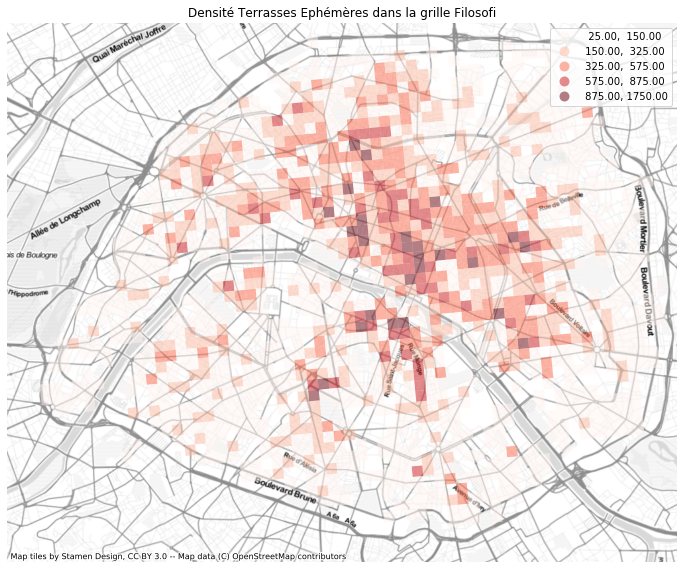

In [30]:
ax = cterrasses.plot('densite', figsize=(12,14), legend=True, scheme='FisherJenksSampled', cmap='Reds', alpha=0.5)
ax.set_axis_off()
cx.add_basemap(ax, crs=sterrasses.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_title("Densité Terrasses Ephémères dans la grille Filosofi")
ax.set_xlim((644601.05,657161.71))
ax.set_ylim((6857121.84,6867229.71))

Cette approche peut être utilisée pour tout type de fond de carte (quartiers, iris...). 

## Carte lissée

Les cartes carroyées sont très sensibles au choix de l'origine (cf [MAUP](https://fr.wikipedia.org/wiki/Probl%C3%A8me_d%E2%80%99agr%C3%A9gation_spatiale)) et peuvent être difficiles à lire car trop chahutées. Le lissage permet d'améliorer la lecture d'un phénomène spatial. Elle repose sur le choix d'un rayon de lissage, ici 500m qui permet de définir l'échelle de restitution du phénomène étudié. 

Le lissage s'obtient à l'aide de la fonction kernelSmoothing :

- sEPSG='2154' : choix de la projection ;
- iCellSize=50 : choix de la taille des carreaux ;
- iBandwidth=500 : choix du rayon de lissage.

In [18]:
lissage = btb.kernelSmoothing(terrasses[['x', 'y', 'densite']], sEPSG='2154', iCellSize=50, iBandwidth=500)

-------------------------------------------------
number of asked cores : 1
-------------------------------------------------
start of smoothing loop
-------------------------------------------------
-------------------------------------------------
end of smoothing loop - duration time in seconds = 0.03660774230957031
-------------------------------------------------
-------------------------------------------------
start of the final grid map cooking
-------------------------------------------------
	-------------------------------------------------
	start of making polygons
	-------------------------------------------------
	-------------------------------------------------
	end of making polygons - duration in seconds = 0.2706151008605957
	-------------------------------------------------
	start of saving geodataframe
	-------------------------------------------------
	-------------------------------------------------
	end of saving geodataframe - duration in seconds = 0.0305507183

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


On calcule à présent la densité en km² :

In [19]:
lissage.densite = lissage.densite / 0.05**2 

Pour obtenir la carte de densité lissée on utilise toujours la fonction plot.

(6857121.84, 6867229.71)

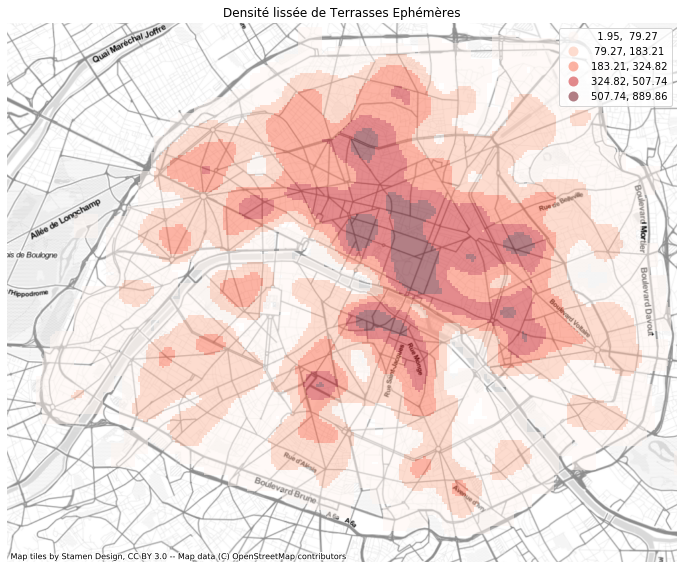

In [20]:
ax = lissage.plot('densite', figsize=(12,14), legend=True, scheme='FisherJenksSampled', cmap='Reds', alpha=0.5)
ax.set_axis_off()
cx.add_basemap(ax, crs=sterrasses.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_title("Densité lissée de Terrasses Ephémères")
ax.set_xlim((644601.05,657161.71))
ax.set_ylim((6857121.84,6867229.71))